# DOWNLOADING DATA

In [34]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from pypfopt.hierarchical_portfolio import HRPOpt
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.covariance import LedoitWolf
import gurobipy as gp
from gurobipy import GRB
import pickle
from pypfopt import base_optimizer



In [2]:
!git clone https://github.com/fja05680/sp500

Cloning into 'sp500'...
remote: Enumerating objects: 365, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 365 (delta 96), reused 77 (delta 58), pack-reused 243 (from 1)
Receiving objects: 100% (365/365), 1.50 MiB | 4.87 MiB/s, done.
Resolving deltas: 100% (258/258), done.


In [3]:
df = pd.read_csv('sp500/S&P 500 Historical Components & Changes(03-10-2025).csv', parse_dates=['date'])
df

,date,tickers
0,1996-01-02,"AAL,AAMRQ,AAPL,ABI,ABS,ABT,ABX,ACKH,ACV,ADM,AD..."
1,1996-01-03,"AAL,AAMRQ,AAPL,ABI,ABS,ABT,ABX,ACKH,ACV,ADM,AD..."
2,1996-01-04,"AAL,AAMRQ,AAPL,ABI,ABS,ABT,ABX,ACKH,ACV,ADM,AD..."
3,1996-01-10,"AAL,AAMRQ,AAPL,ABI,ABS,ABT,ABX,ACKH,ACV,ADM,AD..."
4,1996-01-11,"AAL,AAMRQ,AAPL,ABI,ABS,ABT,ABX,ACKH,ACV,ADM,AD..."
...,...,...
2683,2024-09-23,"A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP..."
2684,2024-09-30,"A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP..."
2685,2024-10-01,"A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP..."
2686,2024-11-26,"A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP..."


In [4]:
tickers = df.iloc[-1]['tickers'].split(',')
tickers = set(map(str.strip, tickers))
tickers.add('^GSPC')

In [5]:
today = pd.to_datetime('today')
start = today - pd.DateOffset(years = 10)

In [6]:
data = yf.download(
    tickers=list(tickers), 
    start=start, 
    end=today,
    auto_adjust=False, 
    progress=True, 
    group_by='ticker'
)

[*********************100%***********************]  504 of 504 completed

2 Failed downloads:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-07-03 21:28:29.861675 -> 2025-07-03 21:28:29.861675)')


In [8]:
data

Ticker            KHC                                                        \
Price            Open       High        Low      Close  Adj Close    Volume   
Date                                                                          
2015-07-06  71.000000  74.290001  71.000000  72.959999  48.088287   3809700   
2015-07-07  73.730003  74.709999  72.959999  74.629997  49.188995   5794300   
2015-07-08  74.300003  75.500000  74.040001  75.400002  49.696507   4276600   
2015-07-09  76.470001  77.066002  74.500000  74.800003  49.301037   4267100   
2015-07-10  75.050003  77.800003  75.000000  77.309998  50.955399   4983000   
...               ...        ...        ...        ...        ...       ...   
2025-06-27  25.850000  25.920000  25.440001  25.610001  25.610001  34119300   
2025-06-30  25.625000  25.870001  25.500000  25.820000  25.820000  18624300   
2025-07-01  25.855000  26.865000  25.830000  26.610001  26.610001  23442300   
2025-07-02  26.660000  27.120001  26.504999  27.059999  27.059999  17009200   
2025-07-03  27.090000  27.150000  26.584999  26.745001  26.745001   5712765   

Ticker              C                                   ...         NOC  \
Price            Open       High        Low      Close  ...         Low   
Date                                                    ...               
2015-07-06  54.790001  55.250000  54.500000  55.080002  ...  158.100006   
2015-07-07  54.970001  55.049999  53.029999  54.500000  ...  158.130005   
2015-07-08  53.810001  53.810001  52.770000  52.799999  ...  160.179993   
2015-07-09  53.840000  54.150002  53.599998  53.709999  ...  162.550003   
2015-07-10  54.549999  54.790001  54.299999  54.560001  ...  163.679993   
...               ...        ...        ...        ...  ...         ...   
2025-06-27  84.489998  84.570000  83.809998  84.379997  ...  489.260010   
2025-06-30  84.900002  85.440002  84.610001  85.120003  ...  493.959991   
2025-07-01  85.000000  86.480003  84.769997  86.269997  ...  496.380005   
2025-07-02  86.489998  86.930000  85.459999  86.760002  ...  489.519989   
2025-07-03  87.129997  88.570000  86.849998  88.400002  ...  498.609985   

Ticker                                             ERIE              \
Price            Close   Adj Close   Volume        Open        High   
Date                                                                  
2015-07-06  159.250000  135.383911   967300   83.029999   83.839996   
2015-07-07  161.389999  137.203186   986300   83.260002   84.510002   
2015-07-08  160.660004  136.582596   888500   83.620003   84.400002   
2015-07-09  162.690002  138.308411  1228800   84.000000   84.260002   
2015-07-10  165.369995  140.586761  1167100   84.129997   84.980003   
...                ...         ...      ...         ...         ...   
2025-06-27  494.000000  494.000000   874300  340.260010  341.559998   
2025-06-30  499.980011  499.980011   644100  340.029999  348.220001   
2025-07-01  503.529999  503.529999   651300  346.970001  354.149994   
2025-07-02  498.899994  498.899994   817400  352.049988  352.049988   
2025-07-03  503.459991  503.459991   197885  344.480011  348.089996   

Ticker                                                  
Price              Low       Close   Adj Close  Volume  
Date                                                    
2015-07-06   82.790001   83.500000   66.731819   27000  
2015-07-07   83.099998   84.400002   67.451088   19700  
2015-07-08   83.099998   83.480003   66.715843   39200  
2015-07-09   83.000000   83.790001   66.963608   30600  
2015-07-10   84.059998   84.830002   67.794716   18400  
...                ...         ...         ...     ...  
2025-06-27  333.329987  340.450012  340.450012  151700  
2025-06-30  338.760010  346.790009  346.790009  139100  
2025-07-01  344.890015  352.049988  352.049988  157900  
2025-07-02  332.339996  343.089996  343.089996  251300  
2025-07-03  344.480011  347.200012  347.200012   30972  

[2515 rows x 3024 columns]

In [9]:
prices = data.xs('Adj Close', level=1, axis=1)
prices

Ticker,KHC,C,LLY,DAL,RJF,SHW,IEX,BA,PM,BKNG,...,SJM,PSA,STZ,ZTS,MCD,ACGL,GPC,EQT,NOC,ERIE
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-06,48.088287,41.587761,72.103867,35.825558,34.006985,84.969940,68.911537,124.454590,49.110847,1127.139771,...,80.494888,127.541756,101.129524,44.890648,74.610535,21.965755,67.136375,39.293392,135.383911,66.731819
2015-07-07,49.188995,41.149837,74.091202,36.445076,33.679443,86.083794,69.307343,126.783913,49.860798,1130.675049,...,81.821182,130.453049,102.243340,44.408337,75.413963,22.032318,67.098846,39.494682,137.203186,67.451088
2015-07-08,49.696507,39.866268,72.855385,35.551201,32.771519,85.267349,68.119850,125.694527,49.334637,1102.956299,...,80.815308,130.859329,100.833664,43.109844,74.758743,21.870667,65.906013,38.825439,136.582596,66.715843
2015-07-09,49.301037,40.553360,73.047447,35.887524,33.127785,84.195984,68.330978,126.473938,49.135052,1111.972046,...,80.696106,131.163956,100.537804,43.193321,75.265785,21.750219,66.221130,39.016655,138.308411,66.963608
2015-07-10,50.955399,41.195148,73.723816,37.577900,33.702427,84.438782,67.908722,127.961876,49.691460,1128.877686,...,80.167038,132.788879,100.972878,43.555046,76.170609,21.997452,66.753792,38.518509,140.586761,67.794716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-27,25.610001,84.379997,775.450012,49.590000,152.730453,345.720001,176.320007,214.550003,181.029999,5693.129883,...,95.629997,289.880005,161.330002,156.169998,291.549988,90.320000,120.480003,58.310001,494.000000,340.450012
2025-06-30,25.820000,85.120003,779.530029,49.180000,152.869995,343.359985,175.570007,209.529999,182.130005,5789.240234,...,98.199997,293.420013,162.679993,155.949997,292.170013,91.050003,121.309998,58.320000,499.980011,346.790009
2025-07-01,26.610001,86.269997,775.900024,49.000000,154.639999,355.299988,180.190002,209.789993,177.529999,5730.729980,...,102.949997,298.089996,166.419998,159.190002,297.489990,91.500000,125.339996,55.720001,503.529999,352.049988


In [10]:
prices = prices.ffill().bfill()
prices = prices.dropna(axis=1, how='all')
prices = prices[sorted(prices.columns)]
prices

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-06,36.274502,28.219820,44.975479,144.710007,41.130566,21.965755,82.638290,80.500000,51.819889,35.814003,...,21.559919,90.775871,24.113523,53.255875,31.981432,54.003380,97.434189,111.839996,44.890648,2068.760010
2015-07-07,36.670807,28.150394,45.199627,144.710007,41.519203,22.032318,83.775925,80.589996,51.648766,35.851231,...,21.784145,97.303535,24.808968,53.475277,32.096119,53.538803,98.311852,112.320000,44.408337,2081.340088
2015-07-08,35.712341,27.451612,44.606300,144.710007,40.725368,21.870667,82.876022,79.989998,50.475296,35.382034,...,21.444403,91.003075,24.677202,52.894501,31.381489,51.889015,96.672890,108.470001,43.109844,2046.680054
2015-07-09,35.869007,26.891697,44.810665,144.710007,40.675755,21.750219,82.986389,80.470001,49.619640,35.069263,...,21.240557,91.929359,24.399027,52.655746,31.355017,52.407177,95.687759,108.440002,43.193321,2051.310059
2015-07-10,36.311371,27.610632,45.641342,144.710007,41.287674,21.997452,83.860832,80.589996,50.124878,35.158630,...,21.260944,90.793335,24.560064,53.055847,31.222681,54.116547,95.660866,109.750000,43.555046,2076.620117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-27,118.919556,201.080002,182.309998,134.520004,134.380005,90.320000,295.459991,385.829987,236.960007,51.980000,...,25.850000,94.680000,67.779999,109.379997,128.229996,148.410004,91.459999,309.260010,156.169998,6173.069824
2025-06-30,117.762001,205.169998,185.619995,132.339996,136.009995,91.050003,298.890015,386.880005,238.020004,52.779999,...,25.690001,93.669998,68.099998,107.800003,129.360001,148.179993,91.209999,308.359985,155.949997,6204.950195
2025-07-01,120.449997,207.820007,189.990005,135.410004,136.259995,91.500000,302.619995,392.100006,240.639999,54.450001,...,26.240000,101.959999,68.709999,109.239998,131.000000,150.369995,94.059998,315.480011,159.190002,6198.009766


In [11]:
prices.columns

Index(['A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM',
       ...
       'WY', 'WYNN', 'XEL', 'XOM', 'XYL', 'YUM', 'ZBH', 'ZBRA', 'ZTS',
       '^GSPC'],
      dtype='object', name='Ticker', length=502)

In [12]:
prices.to_csv('./prices.csv', index_label='Date')

# READING DATA

In [7]:
prices = pd.read_csv('./prices.csv', index_col='Date', parse_dates=True)
prices

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-06,36.274502,28.219820,44.975479,144.710007,41.130566,21.965755,82.638290,80.500000,51.819889,35.814003,...,21.559919,90.775871,24.113523,53.255875,31.981432,54.003380,97.434189,111.839996,44.890648,2068.760010
2015-07-07,36.670807,28.150394,45.199627,144.710007,41.519203,22.032318,83.775925,80.589996,51.648766,35.851231,...,21.784145,97.303535,24.808968,53.475277,32.096119,53.538803,98.311852,112.320000,44.408337,2081.340088
2015-07-08,35.712341,27.451612,44.606300,144.710007,40.725368,21.870667,82.876022,79.989998,50.475296,35.382034,...,21.444403,91.003075,24.677202,52.894501,31.381489,51.889015,96.672890,108.470001,43.109844,2046.680054
2015-07-09,35.869007,26.891697,44.810665,144.710007,40.675755,21.750219,82.986389,80.470001,49.619640,35.069263,...,21.240557,91.929359,24.399027,52.655746,31.355017,52.407177,95.687759,108.440002,43.193321,2051.310059
2015-07-10,36.311371,27.610632,45.641342,144.710007,41.287674,21.997452,83.860832,80.589996,50.124878,35.158630,...,21.260944,90.793335,24.560064,53.055847,31.222681,54.116547,95.660866,109.750000,43.555046,2076.620117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-27,118.919556,201.080002,182.309998,134.520004,134.380005,90.320000,295.459991,385.829987,236.960007,51.980000,...,25.850000,94.680000,67.779999,109.379997,128.229996,148.410004,91.459999,309.260010,156.169998,6173.069824
2025-06-30,117.762001,205.169998,185.619995,132.339996,136.009995,91.050003,298.890015,386.880005,238.020004,52.779999,...,25.690001,93.669998,68.099998,107.800003,129.360001,148.179993,91.209999,308.359985,155.949997,6204.950195
2025-07-01,120.449997,207.820007,189.990005,135.410004,136.259995,91.500000,302.619995,392.100006,240.639999,54.450001,...,26.240000,101.959999,68.709999,109.239998,131.000000,150.369995,94.059998,315.480011,159.190002,6198.009766


In [8]:
benchmark = prices.pop('^GSPC')

log lena hai ya pct ??

In [9]:
pct_returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

In [10]:
corr_pct = pct_returns.corr()
corr_log = log_returns.corr()

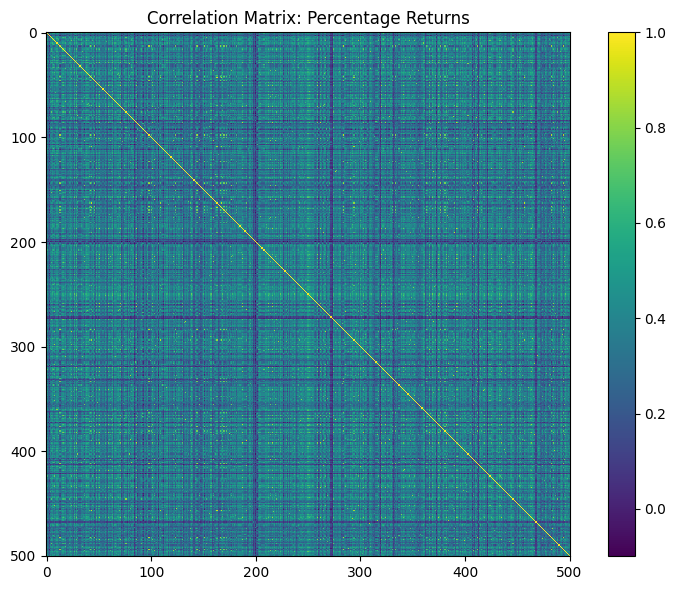

In [11]:
plt.figure(figsize=(8, 6))
plt.imshow(corr_pct, cmap='viridis', interpolation='nearest')
plt.title('Correlation Matrix: Percentage Returns')
plt.colorbar()
plt.tight_layout()
plt.show()

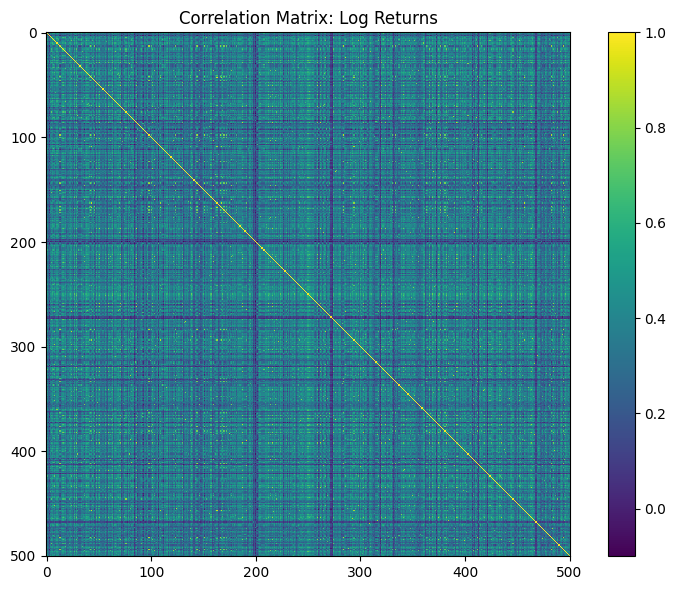

In [12]:
plt.figure(figsize=(8, 6))
plt.imshow(corr_log, cmap='viridis', interpolation='nearest')
plt.title('Correlation Matrix: Log Returns')
plt.colorbar()
plt.tight_layout()
plt.show()

abhi ke liye

In [13]:
corr = corr_pct

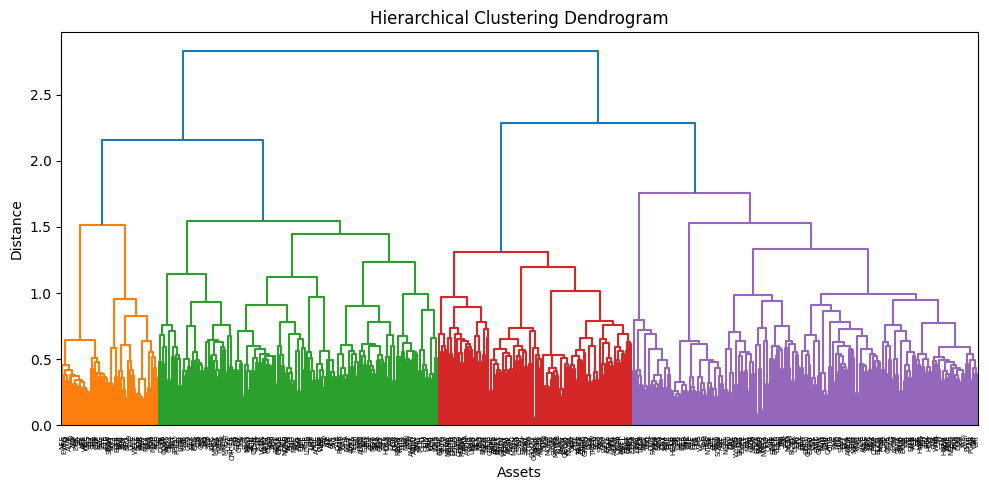

In [14]:
dist_matrix = np.sqrt(0.5 * (1 - corr))
condensed_dist = squareform(dist_matrix.values)

Z = linkage(condensed_dist, method='ward')

plt.figure(figsize=(10, 5))
dendrogram(Z, labels=corr.columns, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Assets')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

In [15]:
assets = corr.columns.tolist()
n_assets = len(assets)

In [16]:
#cluster sizes \forall levels
level_sizes = {
    k: pd.Series(fcluster(Z, t=k, criterion='maxclust')).value_counts().sort_index().tolist()
    for k in range(1, n_assets + 1)
}

In [17]:
for k in [1, 2, 5, 50, n_assets]:
    if k in level_sizes:
        print(f"level {k:3d} : cluster sizes: {level_sizes[k]}")

level   1 : cluster sizes: [501]
level   2 : cluster sizes: [206, 295]
level   5 : cluster sizes: [53, 153, 106, 22, 167]
level  50 : cluster sizes: [26, 5, 10, 12, 5, 8, 5, 7, 12, 4, 24, 5, 11, 5, 12, 12, 14, 6, 12, 6, 5, 5, 3, 11, 5, 2, 2, 21, 8, 15, 16, 8, 10, 2, 20, 28, 17, 4, 4, 8, 9, 11, 4, 2, 13, 14, 6, 13, 9, 25]
level 501 : cluster sizes: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [18]:
#clusters \forall levels
clusters_by_level = {}

for k in range(1, n_assets + 1):
    labels = fcluster(Z, t=k, criterion='maxclust')
    level_clusters = {
        int(cl): [assets[i] for i, lab in enumerate(labels) if lab == cl]
        for cl in np.unique(labels)
    }
    clusters_by_level[k] = level_clusters

In [19]:
print('clusters @ level 50')
for cid, members in clusters_by_level[50].items():
    print(f"cluster {cid}: {members}")

clusters @ level 50
cluster 1: ['AEE', 'AEP', 'ATO', 'AWK', 'CMS', 'CNP', 'D', 'DTE', 'DUK', 'ED', 'EIX', 'ES', 'ETR', 'EVRG', 'EXC', 'FE', 'LNT', 'NEE', 'NI', 'PEG', 'PNW', 'PPL', 'SO', 'SRE', 'WEC', 'XEL']
cluster 2: ['AMT', 'CCI', 'DLR', 'EQIX', 'SBAC']
cluster 3: ['BXP', 'DOC', 'FRT', 'KIM', 'O', 'REG', 'SPG', 'VICI', 'VTR', 'WELL']
cluster 4: ['ARE', 'AVB', 'CPT', 'EQR', 'ESS', 'EXR', 'INVH', 'IRM', 'MAA', 'PLD', 'PSA', 'UDR']
cluster 5: ['COST', 'DG', 'DLTR', 'KR', 'WMT']
cluster 6: ['AZO', 'BBY', 'HD', 'LOW', 'ORLY', 'POOL', 'TGT', 'TSCO']
cluster 7: ['CHD', 'CL', 'CLX', 'KMB', 'PG']
cluster 8: ['CAG', 'CPB', 'GIS', 'HRL', 'K', 'MKC', 'SJM']
cluster 9: ['HSY', 'KDP', 'KHC', 'KO', 'MDLZ', 'MNST', 'MO', 'PEP', 'PM', 'STZ', 'TAP', 'TMUS']
cluster 10: ['CHTR', 'CMCSA', 'T', 'VZ']
cluster 11: ['ACN', 'ADP', 'BR', 'CDW', 'CPAY', 'CPRT', 'CTAS', 'CTSH', 'FDS', 'FI', 'FIS', 'GPN', 'IT', 'JKHY', 'MA', 'MCO', 'MSCI', 'MSI', 'PAYX', 'ROP', 'SPGI', 'V', 'VRSK', 'VRSN']
cluster 12: ['CBOE', 

In [20]:
# google clusters
goog_clusters = [
    (level, cl_id, members)
    for level, clusters in clusters_by_level.items()
    for cl_id, members in clusters.items()
    if 'GOOG' in members
]
goog_clusters.sort(key=lambda x: len(x[2]))

for level, cl_id, members in goog_clusters:
    print(f"level {level}: cluster {cl_id} ({len(members)} members) → {members}")

level 501: cluster 208 (1 members) → ['GOOG']
level 121: cluster 68 (2 members) → ['GOOG', 'GOOGL']
level 122: cluster 69 (2 members) → ['GOOG', 'GOOGL']
level 123: cluster 70 (2 members) → ['GOOG', 'GOOGL']
level 124: cluster 70 (2 members) → ['GOOG', 'GOOGL']
level 125: cluster 70 (2 members) → ['GOOG', 'GOOGL']
level 126: cluster 70 (2 members) → ['GOOG', 'GOOGL']
level 127: cluster 70 (2 members) → ['GOOG', 'GOOGL']
level 128: cluster 71 (2 members) → ['GOOG', 'GOOGL']
level 129: cluster 71 (2 members) → ['GOOG', 'GOOGL']
level 130: cluster 72 (2 members) → ['GOOG', 'GOOGL']
level 131: cluster 72 (2 members) → ['GOOG', 'GOOGL']
level 132: cluster 73 (2 members) → ['GOOG', 'GOOGL']
level 133: cluster 74 (2 members) → ['GOOG', 'GOOGL']
level 134: cluster 75 (2 members) → ['GOOG', 'GOOGL']
level 135: cluster 76 (2 members) → ['GOOG', 'GOOGL']
level 136: cluster 76 (2 members) → ['GOOG', 'GOOGL']
level 137: cluster 77 (2 members) → ['GOOG', 'GOOGL']
level 138: cluster 78 (2 members) → 

In [21]:
# largest cluster \forall levels
for level, clusters in clusters_by_level.items():
    max_cl_id, max_members = max(clusters.items(), key=lambda item: len(item[1]))
    print(f"level {level}: cluster {max_cl_id} ({len(max_members)} members) --> {max_members}")

level 1: cluster 1 (501 members) --> ['A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APO', 'APTV', 'ARE', 'ATO', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXON', 'AXP', 'AZO', 'BA', 'BAC', 'BALL', 'BAX', 'BBY', 'BDX', 'BEN', 'BG', 'BIIB', 'BK', 'BKNG', 'BKR', 'BLDR', 'BLK', 'BMY', 'BR', 'BRO', 'BSX', 'BWA', 'BX', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDNS', 'CDW', 'CE', 'CEG', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP', 'COR', 'COST', 'CPAY', 'CPB', 'CPRT', 'CPT', 'CRL', 'CRM', 'CRWD', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTRA', 'CTSH', 'CTVA', 'CVS', 'CVX', 'CZR', 'D', 'DAL', 'DAY', 'DD', 'DE', 'DECK', 'DELL', 'DFS', 'DG', 'DGX', 'DHI', 

In [22]:
# change points (points of change in largest cluster WITH least number of clusters FOR that largest cluster size)
change_points = []
prev_size = None

for level in sorted(clusters_by_level):
    cl_id, members = max(clusters_by_level[level].items(), key=lambda item: len(item[1]))
    curr_size = len(members)
    if prev_size is None or curr_size != prev_size:
        change_points.append((level, cl_id, members))
    prev_size = curr_size

for level, cl_id, members in change_points:
    print(f"level {level}: cluster {cl_id} ({len(members)} members) --> {members}")


level 1: cluster 1 (501 members) --> ['A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APO', 'APTV', 'ARE', 'ATO', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXON', 'AXP', 'AZO', 'BA', 'BAC', 'BALL', 'BAX', 'BBY', 'BDX', 'BEN', 'BG', 'BIIB', 'BK', 'BKNG', 'BKR', 'BLDR', 'BLK', 'BMY', 'BR', 'BRO', 'BSX', 'BWA', 'BX', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDNS', 'CDW', 'CE', 'CEG', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP', 'COR', 'COST', 'CPAY', 'CPB', 'CPRT', 'CPT', 'CRL', 'CRM', 'CRWD', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTRA', 'CTSH', 'CTVA', 'CVS', 'CVX', 'CZR', 'D', 'DAL', 'DAY', 'DD', 'DE', 'DECK', 'DELL', 'DFS', 'DG', 'DGX', 'DHI', 

In [23]:
change_levels = [level for level, _, _ in change_points]
print(f"# change levels: {len(change_levels)}")

# change levels: 26


\begin{aligned}
& \underset{w\in\mathbb{R}^N,\;z\in\mathbb{R}}{\text{minimize}}
& & z \\[6pt]
& \text{subject to}
& & 
\sum_{i=1}^N w_i = 1
\quad \\[4pt]
& & & 
w_i \ge 0
\quad\forall\,i=1,\dots,N
\quad&&(\text{onlu long}) \\[8pt]
& & & 
z \;\ge\; \sum_{c\in\mathcal C^\ell}
\sum_{i\in c}\sum_{j\in c}
\Sigma_{ij}\,w_i\,w_j
\quad\forall\,\ell\in\mathcal L
\quad&&(\text{cluster‐risk cap})
\end{aligned}


Notation
\begin{aligned}
& N &&= \text{number of assets},\\
& w = (w_1,\dots,w_N) &&= \text{portfolio weights (}w_i\ge0\text{)},\\
& \Sigma = (\Sigma_{ij})_{i,j=1}^N &&= \text{covariance matrix of returns},\\
& \mathcal L = \{\ell_1,\dots,\ell_K\} &&= \text{selected hierarchy levels},\\
& \mathcal C^\ell &&= \{\;c_1^\ell,\dots,c_{m_\ell}^\ell\;\} 
  \;,\;\text{set of clusters at level } \ell,\\
& z &&= \text{auxiliary variable bounding worst‐case cluster risk}.
\end{aligned}


In [24]:
lw = LedoitWolf(store_precision=False, assume_centered=False)
lw.fit(pct_returns.values)
sigma = lw.covariance_

In [25]:
idx = {name: i for i, name in enumerate(assets)}

In [26]:
N = len(assets)

In [27]:
model = gp.Model("clustered_portfolio_optimization")
model.setParam('OutputFlag', 1)

# desc vars
w = model.addVars(N, lb=0.0, name="w")
z = model.addVar(name="z")

# constrs
model.addConstr(gp.quicksum(w[i] for i in range(N)) == 1.0, "budget")
for level in change_levels:
    clusters = clusters_by_level[level]
    risk_expr = gp.QuadExpr()
    
    for members in clusters.values():
        indices = [idx[name] for name in members]
        for i in indices:
            for j in indices:
                risk_expr.add(sigma[i, j] * w[i] * w[j])
    
    model.addQConstr(z >= risk_expr, name=f"risk_level_{level}")
# obj
model.setObjective(z, GRB.MINIMIZE)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2579375
Academic license 2579375 - for non-commercial use only - registered to ma___@iitd.ac.in
Set parameter OutputFlag to value 1


In [28]:
model.optimize()

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)



CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Academic license 2579375 - for non-commercial use only - registered to ma___@iitd.ac.in
Optimize a model with 1 rows, 502 columns and 501 nonzeros
Model fingerprint: 0x1d2da3d5
Model has 26 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [7e-08, 3e-03]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.13s
Presolved: 12578 rows, 13079 columns, 417352 nonzeros
Presolved model has 26 second-order cone constraints
Ordering time: 0.08s

Barrier statistics:
 Dense cols : 509
 AA' NZ     : 5.018e+05
 Factor NZ  : 6.546e+05 (roughly 17 MB of memory)
 Factor Ops : 1.315e+08 (roughly 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time


In [29]:
print(f"optimal z: {z.X:.6f}")
print("weights:", [w[i].X for i in range(N)])

optimal z: 0.001303
weights: [0.0009315796390316509, 0.00042226140265151673, 0.003458021716067235, 0.000933960887057082, 0.0011127094191258537, 0.003529662586933192, 0.001152169174420925, 0.0005567472115732168, 0.00024904474336368834, 0.0010343250686545833, 0.000980860571168332, 0.0003176488792847154, 0.0021214837120730116, 0.002479155008221873, 0.00028246952514201194, 0.0017234558450843253, 0.001956591215964112, 0.002714011411455238, 0.0008734098062676543, 0.001739097215151911, 0.001573478023445466, 0.006672605829120381, 0.002184625910536427, 0.0006352803490667066, 0.0007919262266651684, 0.0014734047362616096, 0.007545688852987141, 0.0003061744790346236, 0.0016731854768748734, 0.0003457355764285245, 0.0026498420040729134, 0.0005375789123073249, 0.0018448172366483044, 0.0002496503507930835, 0.001791236804156409, 0.0009197007165619412, 0.011243502307586322, 0.0008151278113119342, 8.459796398685727e-05, 0.000448063860615832, 0.0006658561959900142, 0.00046044401978355393, 0.00190153474419

In [30]:
weights = np.array([w[i].X for i in range(N)])
np.save("portfolio_weights.npy", weights)

In [31]:
with open("idx.pkl", "wb") as f:
    pickle.dump(idx, f)

In [32]:
len(idx) == len(weights)

True

# Analysis

In [2]:
weights = np.load("portfolio_weights.npy")
with open("idx.pkl", "rb") as f:
    idx = pickle.load(f)


In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500 = pd.read_html(url)[0]

sector_groups = sp500.groupby("GICS Sector")["Symbol"].apply(list)
tot = 0
for sector, tickers in sector_groups.items():
    tot += len(tickers)
    print(f"\n{sector} ({len(tickers)} tickers):")
    print(tickers)


Communication Services (23 tickers):
['GOOGL', 'GOOG', 'T', 'CHTR', 'CMCSA', 'EA', 'FOXA', 'FOX', 'IPG', 'LYV', 'MTCH', 'META', 'NFLX', 'NWSA', 'NWS', 'OMC', 'PARA', 'TMUS', 'TTWO', 'TKO', 'VZ', 'DIS', 'WBD']

Consumer Discretionary (51 tickers):
['ABNB', 'AMZN', 'APTV', 'AZO', 'BBY', 'BKNG', 'CZR', 'KMX', 'CCL', 'CMG', 'DRI', 'DECK', 'DPZ', 'DASH', 'DHI', 'EBAY', 'EXPE', 'F', 'GRMN', 'GM', 'GPC', 'HAS', 'HLT', 'HD', 'LVS', 'LEN', 'LKQ', 'LOW', 'LULU', 'MAR', 'MCD', 'MGM', 'MHK', 'NKE', 'NCLH', 'NVR', 'ORLY', 'POOL', 'PHM', 'RL', 'ROST', 'RCL', 'SBUX', 'TPR', 'TSLA', 'TJX', 'TSCO', 'ULTA', 'WSM', 'WYNN', 'YUM']

Consumer Staples (38 tickers):
['MO', 'ADM', 'BF.B', 'BG', 'CPB', 'CHD', 'CLX', 'KO', 'CL', 'CAG', 'STZ', 'COST', 'DG', 'DLTR', 'EL', 'GIS', 'HSY', 'HRL', 'K', 'KVUE', 'KDP', 'KMB', 'KHC', 'KR', 'LW', 'MKC', 'TAP', 'MDLZ', 'MNST', 'PEP', 'PM', 'PG', 'SJM', 'SYY', 'TGT', 'TSN', 'WBA', 'WMT']

Energy (23 tickers):
['APA', 'BKR', 'CVX', 'COP', 'CTRA', 'DVN', 'FANG', 'EOG', 'EQT',

In [4]:
tot

502

In [6]:
idx

{'A': 0,
 'AAPL': 1,
 'ABBV': 2,
 'ABNB': 3,
 'ABT': 4,
 'ACGL': 5,
 'ACN': 6,
 'ADBE': 7,
 'ADI': 8,
 'ADM': 9,
 'ADP': 10,
 'ADSK': 11,
 'AEE': 12,
 'AEP': 13,
 'AES': 14,
 'AFL': 15,
 'AIG': 16,
 'AIZ': 17,
 'AJG': 18,
 'AKAM': 19,
 'ALB': 20,
 'ALGN': 21,
 'ALL': 22,
 'ALLE': 23,
 'AMAT': 24,
 'AMCR': 25,
 'AMD': 26,
 'AME': 27,
 'AMGN': 28,
 'AMP': 29,
 'AMT': 30,
 'AMZN': 31,
 'ANET': 32,
 'ANSS': 33,
 'AON': 34,
 'AOS': 35,
 'APA': 36,
 'APD': 37,
 'APH': 38,
 'APO': 39,
 'APTV': 40,
 'ARE': 41,
 'ATO': 42,
 'AVB': 43,
 'AVGO': 44,
 'AVY': 45,
 'AWK': 46,
 'AXON': 47,
 'AXP': 48,
 'AZO': 49,
 'BA': 50,
 'BAC': 51,
 'BALL': 52,
 'BAX': 53,
 'BBY': 54,
 'BDX': 55,
 'BEN': 56,
 'BG': 57,
 'BIIB': 58,
 'BK': 59,
 'BKNG': 60,
 'BKR': 61,
 'BLDR': 62,
 'BLK': 63,
 'BMY': 64,
 'BR': 65,
 'BRO': 66,
 'BSX': 67,
 'BWA': 68,
 'BX': 69,
 'BXP': 70,
 'C': 71,
 'CAG': 72,
 'CAH': 73,
 'CARR': 74,
 'CAT': 75,
 'CB': 76,
 'CBOE': 77,
 'CBRE': 78,
 'CCI': 79,
 'CCL': 80,
 'CDNS': 81,
 'CDW': 82

In [13]:
assets = list(idx.keys())
N = len(assets)

In [14]:
weight_map = {assets[i]: weights[i] for i in range(N)}

In [15]:
sector_weight = {}
for sector, tickers in sector_groups.items():
    total_weight = 0.0
    for ticker in tickers:
        if ticker in weight_map:
            total_weight += weight_map[ticker]
        else:
            print(f"{ticker} NOT FOUND")
    sector_weight[sector] = total_weight

TKO NOT FOUND
DASH NOT FOUND
WSM NOT FOUND
BF.B NOT FOUND
EXE NOT FOUND
BRK.B NOT FOUND
COIN NOT FOUND


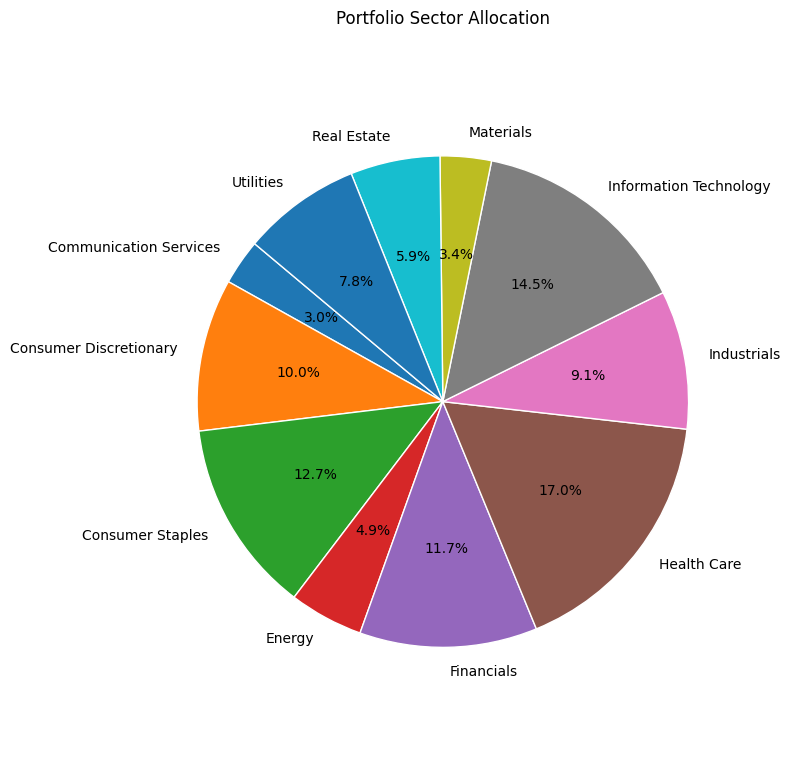

In [16]:
labels, sizes = zip(*[(sector, weight) for sector, weight in sector_weight.items() if weight > 0])
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, wedgeprops=dict(edgecolor='w'))
plt.title("Portfolio Sector Allocation")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [17]:
# https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks

In [18]:
info = pd.read_csv('/Users/harshit/Desktop/portopt/sp500_companies.csv')
info = info.sort_values(by='Symbol')

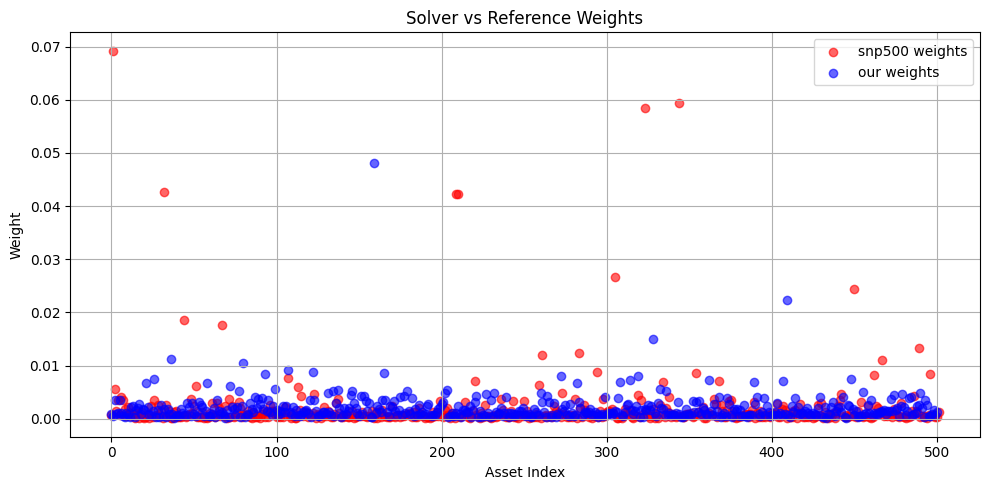

In [19]:
plt.figure(figsize=(10, 5))
plt.scatter(range(502), info['Weight'], color='red', alpha=0.6, label='snp500 weights')
plt.scatter(range(N), weights, color='blue', alpha=0.6, label='our weights')
plt.title("Solver vs Reference Weights")
plt.xlabel("Asset Index")
plt.ylabel("Weight")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


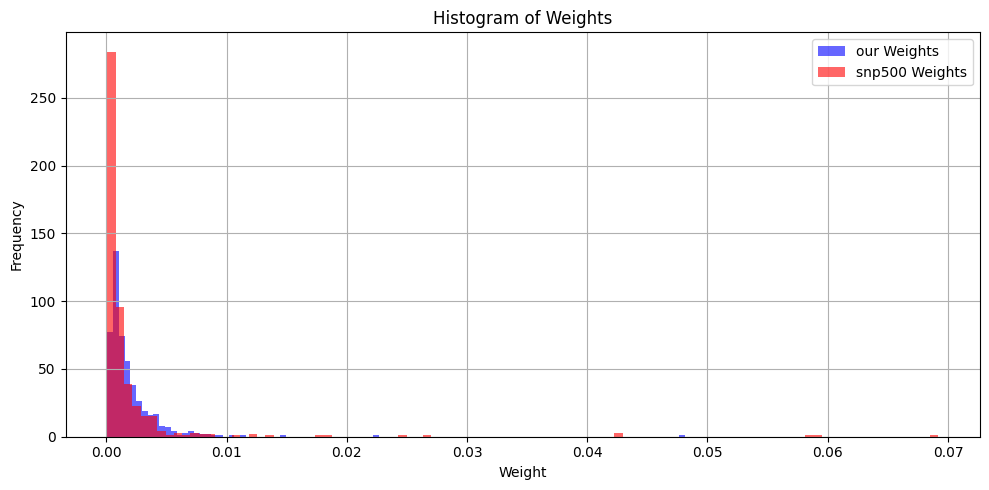

In [23]:
plt.figure(figsize=(10, 5))
plt.hist(weights, bins=100, alpha=0.6, label='our Weights', color='blue')
plt.hist(info['Weight'], bins=100, alpha=0.6, label='snp500 Weights', color='red')
plt.title("Histogram of Weights")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
max_idx = np.argmax(weights)
print(f"max : {weights[max_idx]:.4f} --> {assets[max_idx]}")

max : 0.0481 --> ENPH


In [29]:
prices = pd.read_csv('./prices.csv', index_col='Date', parse_dates=True)
benchmark = prices.pop('^GSPC')
pct_returns = prices.pct_change().dropna()

In [30]:
hrp = HRPOpt(returns=pct_returns)
hrp.optimize(linkage_method="ward")
hrp_weights = hrp.clean_weights()
performance = hrp.portfolio_performance(verbose=True)

Expected annual return: 12.9%
Annual volatility: 14.2%
Sharpe Ratio: 0.91


In [31]:
weight_map

{'A': 0.0009315796390316509,
 'AAPL': 0.00042226140265151673,
 'ABBV': 0.003458021716067235,
 'ABNB': 0.000933960887057082,
 'ABT': 0.0011127094191258537,
 'ACGL': 0.003529662586933192,
 'ACN': 0.001152169174420925,
 'ADBE': 0.0005567472115732168,
 'ADI': 0.00024904474336368834,
 'ADM': 0.0010343250686545833,
 'ADP': 0.000980860571168332,
 'ADSK': 0.0003176488792847154,
 'AEE': 0.0021214837120730116,
 'AEP': 0.002479155008221873,
 'AES': 0.00028246952514201194,
 'AFL': 0.0017234558450843253,
 'AIG': 0.001956591215964112,
 'AIZ': 0.002714011411455238,
 'AJG': 0.0008734098062676543,
 'AKAM': 0.001739097215151911,
 'ALB': 0.001573478023445466,
 'ALGN': 0.006672605829120381,
 'ALL': 0.002184625910536427,
 'ALLE': 0.0006352803490667066,
 'AMAT': 0.0007919262266651684,
 'AMCR': 0.0014734047362616096,
 'AMD': 0.007545688852987141,
 'AME': 0.0003061744790346236,
 'AMGN': 0.0016731854768748734,
 'AMP': 0.0003457355764285245,
 'AMT': 0.0026498420040729134,
 'AMZN': 0.0005375789123073249,
 'ANET'

In [35]:
def portfolio_performance(weights, returns, verbose=False, risk_free_rate=0.02, frequency=252):
    if returns is None:
        cov = cov_matrix
        mu = None
    else:
        cov = returns.cov() * frequency
        mu = returns.mean() * frequency

    return base_optimizer.portfolio_performance(
        weights, mu, cov, verbose, risk_free_rate
    )

portfolio_performance(weight_map , pct_returns)

(0.18022235156910751, 0.18755309693355715, 0.8542772910109191)

In [36]:
# Expected annual return: 18.02%
# Annual volatility: 18.73%
# Sharpe Ratio: 0.85


In [40]:
info.sort_values(by=['Symbol'])[['Symbol','Weight']]

,Symbol,Weight
242,A,0.000691
0,AAPL,0.069209
25,ABBV,0.005582
117,ABNB,0.001509
43,ABT,0.003565
...,...,...
299,XYL,0.000512
251,YUM,0.000665
355,ZBH,0.000384
366,ZBRA,0.000365


In [42]:
info = info[info['Symbol'].isin(assets)].copy()
info

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
242,NYQ,A,"Agilent Technologies, Inc.","Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,134.51,38415384576,1.564000e+09,-0.056,Santa Clara,CA,United States,17400.0,"Agilent Technologies, Inc. provides applicatio...",0.000691
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,254.49,3846819807232,1.346610e+11,0.061,Cupertino,CA,United States,164000.0,"Apple Inc. designs, manufactures, and markets ...",0.069209
25,NYQ,ABBV,AbbVie Inc.,AbbVie Inc.,Healthcare,Drug Manufacturers - General,175.58,310274424832,2.563000e+10,0.038,North Chicago,IL,United States,50000.0,"AbbVie Inc. discovers, develops, manufactures,...",0.005582
117,NMS,ABNB,"Airbnb, Inc.","Airbnb, Inc.",Consumer Cyclical,Travel Services,134.21,83850649600,1.673000e+09,0.099,San Francisco,CA,United States,6907.0,"Airbnb, Inc., together with its subsidiaries, ...",0.001509
43,NYQ,ABT,Abbott Laboratories,Abbott Laboratories,Healthcare,Medical Devices,114.23,198127370240,1.082500e+10,0.049,North Chicago,IL,United States,114000.0,"Abbott Laboratories, together with its subsidi...",0.003565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,NYQ,XYL,Xylem Inc.,Xylem Inc.,Industrials,Specialty Industrial Machinery,117.14,28458575872,1.689000e+09,0.013,Washington,DC,United States,23000.0,"Xylem Inc., together with its subsidiaries, en...",0.000512
251,NYQ,YUM,"Yum! Brands, Inc.","Yum! Brands, Inc.",Consumer Cyclical,Restaurants,132.36,36937969664,2.608000e+09,0.069,Louisville,KY,United States,35000.0,"Yum! Brands, Inc., together with its subsidiar...",0.000665
355,NYQ,ZBH,"Zimmer Biomet Holdings, Inc.","Zimmer Biomet Holdings, Inc.",Healthcare,Medical Devices,107.12,21324808192,2.557400e+09,0.040,Warsaw,IN,United States,18000.0,"Zimmer Biomet Holdings, Inc., together with it...",0.000384
366,NMS,ZBRA,Zebra Technologies Corporation,Zebra Technologies Corporation,Technology,Communication Equipment,393.04,20273004544,8.030000e+08,0.313,Lincolnshire,IL,United States,9750.0,"Zebra Technologies Corporation, together with ...",0.000365


In [43]:
true_weights = info['Weight'].values
true_pct_returns = pct_returns[info['Symbol']].values

In [48]:
portfolio_performance(true_weights , pd.DataFrame(true_pct_returns))

(0.24208710138149703, 0.20011824924616645, 1.1097793540473493)

In [49]:
# Expected annual return: 24.20%
# Annual volatility: 20.01%
# Sharpe Ratio: 1.11

1. extra constraints (dro cvar)
2. bettr sigma
3. returns expected (NOISE)